# YouTube URL Analysis

## Preface
### Data descriptions

In [1]:
sample_size = 100000000 # specifies the sample size
sample_size = 10000000
debug = False
extract_hosts = False
parallel = True
if sample_size > 100000000:
    parallel = False
limit = 15  # specifies the number of elements in lists and graphs
n_cores = 12 # number of cores to use for parallelization

url_columns = ["id", "hash", "channelId", "publishedAt", "url", "resolvedUrl", "domain","resolved","dead","status_code"]
video_columns = ["id","hash","channelId","channelTitle","publishedAt","title","description","tags","categoryId","defaultLanguage","defaultAudioLanguage","duration","dimension","definition","caption","licensedContent","allowedIn","blockedIn","viewCount","likeCount","dislikeCount","favoriteCount","commentCount","requesttime"]
channel_columns = ["id","title","description","subscriberCount","videoCount","commentCount","viewCount","featuring","subscribing","country","publishedAt","daysactive","keywords","topics","wikitopics"]

### Import necessary modules

In [2]:
import numpy as np
import pandas as pd
import csv
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(14,8.27)})
from multiprocessing import Pool
import os, gc
import re

### Load data

In [3]:
# load URLs csv
pd_url_data = pd.read_csv('sample_' + str(sample_size) + '.csv', names=url_columns)
if debug:
    pd_url_data.info(verbose=False, memory_usage="deep")

In [4]:
# cast columns in right type
pd_url_data['date'] = pd.to_datetime(pd_url_data["publishedAt"]).dt.date
pd_url_data['year'] = pd.to_datetime(pd_url_data["publishedAt"]).dt.year

# skip everything before 1 december 2019
pd_url_data = pd_url_data[pd_url_data['date'] < datetime.date(year=2019, month=12, day=1)]
print("min date: %s, max date: %s\n" % (min(pd_url_data.date),max(pd_url_data.date)))

if debug:
    pd_url_data.info(verbose=False, memory_usage="deep")

min date: 2005-11-12, max date: 2019-11-30



In [5]:
# get rid of columns we don't need
pd_url_data = pd_url_data[["id", "hash", "channelId", "date", "year", "resolvedUrl", "resolved", "dead"]]
if debug:
    pd_url_data.info(verbose=False, memory_usage="deep")

### Check 'dead' URLs + how many have not yet been checked 

Info for full data set:
* 249.790 unique URLs are unresolved. They are all URLs that have a wrong format (either because of a parsing mistake, or because they were written as such in the video description). 
* when counting duplicates as well, this amounts to 4.709.688 URLs

In [6]:
# count URLs marked as dead on expansion
pd_url_data_dead = len(pd_url_data.query("dead==1"))
# count total number of URLs
total = len(pd_url_data)
# calculate percentage
percent_dead = round(pd_url_data_dead/total*100,2) 
# print percentage
print("Total URLS: %s, of which %s (%s%%) dead" % (total, pd_url_data_dead, percent_dead))

# unchecked if resolved = 0 and dead = 0
pd_url_data_unchecked = len(pd_url_data.query('resolved==0 & dead==0'))
percent_unchecked = round(pd_url_data_unchecked/total*100,2)
print("Total URLS: %s, of which %s (%s%%) could NOT be resolved" % (total, pd_url_data_unchecked, percent_unchecked))

# get rid of columns we don't need
pd_url_data = pd_url_data[["id", "hash", "channelId", "year","resolvedUrl"]]

# free up even more memory
del pd_url_data_dead
del pd_url_data_unchecked
gc.collect();

if debug:
    pd_url_data.info(verbose=False, memory_usage="deep")



Total URLS: 9884027, of which 363217 (3.67%) dead
Total URLS: 9884027, of which 81124 (0.82%) could NOT be resolved


### Clean data

In [7]:
# load list of icann tlds and stlds
from icann_domains import icann_domains
pd_icann_domains = pd.Series(icann_domains)
pd_icann_domains_stld = pd_icann_domains[pd_icann_domains.str.contains("\.")]  # filter for second/third/... level tld
pd_icann_domains_stld = '.' + pd_icann_domains_stld.astype(str) # make sure we will filter on stld, rather than part of domain


In [8]:
# function that checks whether a URL ends with an icann stld and extracts proper host name
# @todo, super costly function. See whether it can be improved
def get_host(url):
    try:
        if url.endswith(tuple(pd_icann_domains_stld)): # check whether url ends in stld
            stld_found = next((stld for stld in pd_icann_domains_stld if url.endswith(str(stld))), None)  # find which stld it ends with
            if stld_found is not None:
                return re.sub(".*?([^.]+\\" + stld_found + ")$", r"\1", url)  # get host as non-dotted word before (and incl) stld
            else:
                return re.sub('.*?([^.]+\.[^.]+)$', r"\1", url)
        else:
            return re.sub('.*?([^.]+\.[^.]+)$', r"\1", url)
    except:
        return ''

def clean_data_wrapped(df):
    try:
        return clean_data(df)
    except:
        print("%s Except in clean_data_wrapped"%(now_string()))
        return False # @todo, warning this is just for testing!

def now_string():
    return datetime.datetime.now().strftime("%H:%M:%S")

# function to clean data: clean up URLs, remove slashes, extract host
def clean_data(df,dohost=True):
    if debug:
        print("%s pid child %s length = %s" % (now_string(), os.getpid(), len(df)))

    # remove trailing slash
    df.replace({'resolvedUrl': r'/\)?$'}, {'resolvedUrl':''}, regex=True, inplace=True)

    # override domain from URL extraction
    df['domain'] = df['resolvedUrl'].replace('https?://([^/:#]+).*', r'\1', regex=True)  # extract full domain (don't rely on extracted stuff in db)

    # lowercase all domains
    df['domain'] = df['domain'].str.lower()

    # remove all www. or www2.
    df.replace({'domain': r'^www2?\.'}, {'domain': ''}, regex=True, inplace=True)

    if debug:
        print("%s pid child %s cleaned URLs done"%(now_string(), os.getpid()))

    # replace common abbreviations
    df.replace({'domain': 'youtu.be'}, {'domain': 'youtube.com'}, regex=True, inplace=True)
    df.replace({'domain': 'fb.com'}, {'domain': 'facebook.com'}, regex=True, inplace=True)
    df.replace({'domain': 'm.facebook.com'}, {'domain': 'facebook.com'}, regex=True, inplace=True)
    # df.replace({'domain': r'^open\.spotify'}, {'domain': 'spotify'}, regex=True, inplace=True)

    if debug:
        print("%s pid child %s domain replacements done"%(now_string(), os.getpid()))    

    if extract_hosts:
        if dohost:
            # get host based on icann (s)tlds
            df['host'] = df['domain'].apply(get_host)

            if debug:
                print("%s pid child %s get hosts done"%(now_string(), os.getpid()))

    return df

# function to parallelize dataframe computation
def parallelize_dataframe(df, func, n_cores):
    
    if debug:
        df.info(verbose=False, memory_usage="deep")
    
    # split data frame
    df_split = np.array_split(df, n_cores)
    df = pd.DataFrame()
    
    if debug:
        df.info(verbose=False, memory_usage="deep")

    # start multi-processing
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    if debug:
        print("join length %s" % (len(df)))
    pool.close()
    pool.join()
    return df

if parallel:
    if debug:
        print("start length %s"%(len(pd_url_data)))
    pd_url_data = parallelize_dataframe(pd_url_data, clean_data_wrapped, n_cores)

else: # clean data: clean up URLs, remove slashes, extract host
    # remove trailing slash
    pd_url_data.replace({'resolvedUrl': r'/\)?$'}, {'resolvedUrl': ''}, regex = True, inplace = True)

    # override domain from URL extraction
    pd_url_data['domain'] = pd_url_data['resolvedUrl'].replace('https?://([^/:#]+).*', r'\1', regex=True)  # extract full domain (don't rely on extracted stuff in db)

    # remove all www. or www2.
    pd_url_data.replace({'domain': r'^www2?\.'}, {'domain': ''}, regex=True, inplace=True)

    # lowercase all domains
    pd_url_data['domain'] = pd_url_data['domain'].str.lower()

    if debug:
        print("%s cleaned URLs done"%(now_string()))

    # replace common abbreviations
    pd_url_data.replace({'domain': 'youtu.be'}, {'domain': 'youtube.com'}, regex=True, inplace=True)
    pd_url_data.replace({'domain': 'fb.com'}, {'domain': 'facebook.com'}, regex=True, inplace=True)
    pd_url_data.replace({'domain': 'm.facebook.com'}, {'domain': 'facebook.com'}, regex=True, inplace=True)
    # df.replace({'domain': r'^open\.spotify'}, {'domain': 'spotify'}, regex=True, inplace=True)

    if debug:
        print("%s domain replacements done"%(now_string()))    

    if extract_hosts:
        # get host based on icann (s)tlds
        pd_url_data['host'] = pd_url_data['domain'].apply(get_host)

        if debug:
            print("%s get hosts done"%(now_string()))

# Generic analysis

In [9]:
print("Basic stats on int/float columns")
with pd.option_context('display.precision', 2):
    display(pd_url_data.describe())

Basic stats on int/float columns


,id,year
count,9.88e+06,9.88e+06
mean,2.89e+08,2.02e+03
std,1.67e+08,2.01e+00
min,1.10e+02,2.00e+03
25%,1.44e+08,2.02e+03
50%,2.89e+08,2.02e+03
75%,4.33e+08,2.02e+03
max,5.78e+08,2.02e+03


## Basic stats (based on videos, not channels)

### Number of URLs per year

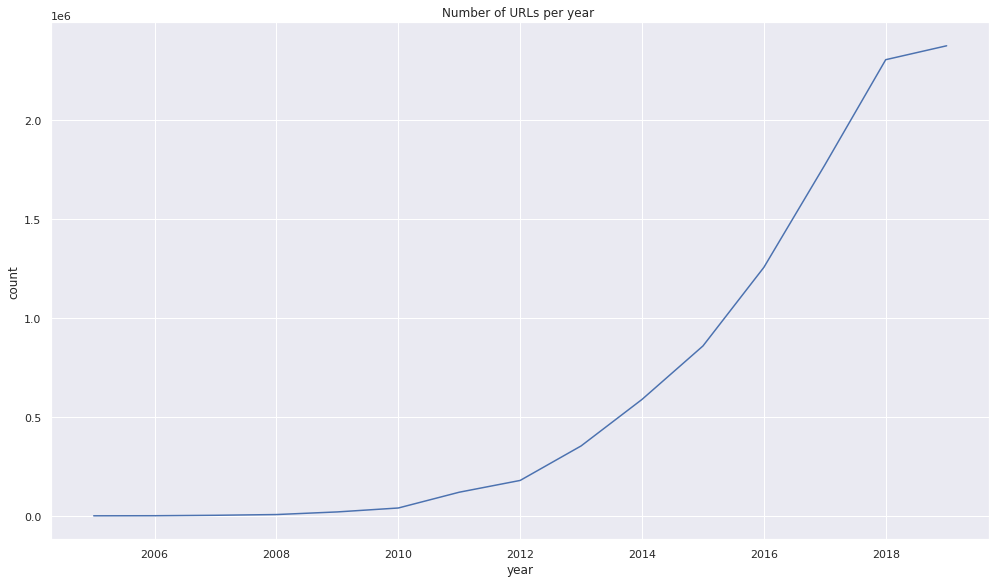

In [27]:
# count URL per year
pd_url_data['count'] = 1
pd_url_data_UrlsPerYear = pd_url_data.groupby(["year"]).count()['count'].reset_index()
# print(pd_url_data_UrlsPerYear)
# pd_url_data_videosWithUrlsPerYear = pd_url_data.groupby('year')['hash'].nunique().reset_index()
# print(pd_url_data_videosWithUrlsPerYear)

plt.figure()
sns.lineplot(x="year", y="count",markers=True, dashes=False, data=pd_url_data_UrlsPerYear)
plt.title("Number of URLs per year ")
plt.tight_layout()


### Channel and domain counts

In [11]:
# count unique videos for each channel
videoCountForChannel = pd_url_data.groupby('channelId')['hash'].nunique()
# add videoCountForChannel as column
pd_url_data['videoCountForChannel'] = pd_url_data['channelId'].map(videoCountForChannel)

# count unique videos for each domain
videoCountForDomain = pd_url_data.groupby('domain')['hash'].nunique()
# add videoCountForDomain as column
pd_url_data['videoCountForDomain'] = pd_url_data['domain'].map(videoCountForDomain)

# count unique channels for domain
channelCountForDomain = pd_url_data.groupby('domain')['channelId'].nunique()
# add channelCountForDomain as column
pd_url_data['channelCountForDomain'] = pd_url_data['domain'].map(channelCountForDomain)

# add channels/videos for domains
pd_url_data['channelDivVideoForDomain'] = round(pd_url_data['channelCountForDomain'] / pd_url_data['videoCountForDomain'], 2)

### Top domains

In [12]:
# reset count column
pd_url_data['count'] = 1 
# count domains in URLs data set and sort in reverse
pd_url_data_groupedDomain = pd_url_data.groupby(["domain"]).count()['count'].sort_values(ascending=False).reset_index()
# add diversity measure
pd_url_data_groupedDomain['videoCountForDomain'] = pd_url_data_groupedDomain['domain'].map(videoCountForDomain)
pd_url_data_groupedDomain['channelCountForDomain'] = pd_url_data_groupedDomain['domain'].map(channelCountForDomain)
pd_url_data_groupedDomain['channelDivVideoForDomain'] = pd_url_data_groupedDomain['channelCountForDomain'] / pd_url_data_groupedDomain['videoCountForDomain']

# print header
print("Top %s domains" % (limit)) 
# print most used domains overall
with pd.option_context('display.precision', 3):
    display(pd_url_data_groupedDomain[['domain','count','channelCountForDomain','videoCountForDomain','channelDivVideoForDomain']].head(limit).style.hide_index()) 

Top 15 domains


domain,count,channelCountForDomain,videoCountForDomain,channelDivVideoForDomain
youtube.com,3466804,86863,3190394,0.03
facebook.com,1170356,63564,1164029,0.05
twitter.com,925187,46679,921981,0.05
instagram.com,554268,54940,551791,0.10
plus.google.com,132738,5622,132652,0.04
play.google.com,108553,8618,108174,0.08
amazon.com,104117,9086,95281,0.10
twitch.tv,98485,8351,96787,0.09
vk.com,95017,6038,94109,0.06
soundcloud.com,55173,9142,54590,0.17


### Which domains for 80% coverage?

In [13]:
total_urls = sum(pd_url_data_groupedDomain['count'])
pd_url_data_groupedDomain.loc[0, 'cummulative_percent'] = pd_url_data_groupedDomain.loc[0, 'count'] / total_urls
for i in range(1, len(pd_url_data_groupedDomain)):
    pd_url_data_groupedDomain.loc[i, 'cummulative_percent'] = pd_url_data_groupedDomain.loc[i - 1, 'cummulative_percent'] + (pd_url_data_groupedDomain.loc[i, 'count'] / total_urls)

print('Total URLs: %s' % (total_urls))
print('Unique domains: %s' % (len(pd_url_data_groupedDomain)))

with pd.option_context('display.precision', 3):
    display(pd_url_data_groupedDomain[pd_url_data_groupedDomain['cummulative_percent'] <= 0.8])

Total URLs: 9444532
Unique domains: 115615


,domain,count,videoCountForDomain,channelCountForDomain,channelDivVideoForDomain,cummulative_percent
0,youtube.com,3466804,3190394,86863,2.72e-02,0.37
1,facebook.com,1170356,1164029,63564,5.46e-02,0.49
2,twitter.com,925187,921981,46679,5.06e-02,0.59
3,instagram.com,554268,551791,54940,9.96e-02,0.65
4,plus.google.com,132738,132652,5622,4.24e-02,0.66
...,...,...,...,...,...,...
68,aporasal.net,4951,4683,614,1.31e-01,0.80
69,aliexpress.com,4899,4447,1199,2.70e-01,0.80
70,onlinedatinglogic.com,4821,4033,1,2.48e-04,0.80
71,roblox.com,4797,4745,566,1.19e-01,0.80


### Top domains per year: data for rank flow

In [14]:
#group by count and get top %%limit%% per year
pd_domains_by_year = pd_url_data.groupby(['year', 'domain']).count()['count'].reset_index().sort_values(ascending=False,by='count').groupby(['year']).head(limit).sort_values(ascending=False,by=['year','count'])

#pivot
pd_domains_by_year_pivot = pd_domains_by_year.pivot(index='domain',columns='year',values='count').reset_index()
pd_domains_by_year_pivot = pd_domains_by_year_pivot.set_index('domain')

# put in rankflow format
pd_rankflow = pd.DataFrame(range(0,limit))
for year, col in pd_domains_by_year_pivot.iteritems():
    col = col.dropna()
    col = col.sort_values(ascending=False)
    new = pd.DataFrame({str(year):col.index, str(year)+'_count':col.values})
    pd_rankflow = pd.concat([pd_rankflow,new],axis=1)

# pretty print
del pd_rankflow[0]
pd_rankflow = pd_rankflow.apply(lambda x: pd.Series(x.dropna().values)).fillna('')
with pd.option_context('display.precision', 0):
    display(pd_rankflow.style.hide_index()) 

2005,2005_count,2006,2006_count,2007,2007_count,2008,2008_count,2009,2009_count,2010,2010_count,2011,2011_count,2012,2012_count,2013,2013_count,2014,2014_count,2015,2015_count,2016,2016_count,2017,2017_count,2018,2018_count,2019,2019_count
youtube.com,3,youtube.com,94,youtube.com,631,youtube.com,1256,youtube.com,6542,youtube.com,12942,youtube.com,39425,youtube.com,51274,youtube.com,105556,youtube.com,191356,youtube.com,293828,youtube.com,445567,youtube.com,631685,youtube.com,834910,youtube.com,851735
click.linksynergy.com,2,facebook.com,39,twitter.com,231,facebook.com,569,twitter.com,1669,facebook.com,3095,facebook.com,10434,facebook.com,23891,facebook.com,46857,facebook.com,72528,facebook.com,104605,facebook.com,150954,facebook.com,211936,facebook.com,269880,facebook.com,273756
club.marcomontemagno.it,2,twitter.com,33,facebook.com,227,twitter.com,521,facebook.com,1585,twitter.com,2968,twitter.com,8834,twitter.com,19711,twitter.com,37256,twitter.com,60407,twitter.com,87329,twitter.com,121206,twitter.com,164131,twitter.com,209510,twitter.com,211381
axs.com,1,amazon.com,10,instagram.com,94,instagram.com,204,instagram.com,548,mahalo.com,2581,mahalo.com,7632,instagram.com,3876,instagram.com,7853,instagram.com,18287,instagram.com,34704,instagram.com,62035,instagram.com,99624,instagram.com,147239,instagram.com,176936
marcomontemagno.it,1,instagram.com,10,amazon.com,69,plus.google.com,154,plus.google.com,266,instagram.com,938,french4you.net,6294,amazon.com,1965,plus.google.com,4409,plus.google.com,9594,plus.google.com,14755,plus.google.com,18834,plus.google.com,24731,plus.google.com,33638,play.google.com,33789
,,open.spotify.com,8,plus.google.com,59,banggood.com,102,banggood.com,256,po.st,448,french4me.net,4650,plus.google.com,1571,twitch.tv,3654,twitch.tv,7402,twitch.tv,11255,vk.com,14551,amazon.com,21722,play.google.com,29101,amazon.com,26267
,,podcasts.apple.com,6,banggood.com,40,amazon.com,87,ocremix.org,225,zee5.com,414,pinterest.com,2092,program.kbs.co.kr,1510,vk.com,3632,vk.com,7107,vk.com,10092,twitch.tv,14294,vk.com,19471,amazon.com,26348,plus.google.com,23684
,,twitch.tv,6,twitch.tv,35,po.st,63,amazon.com,179,plus.google.com,353,instagram.com,1920,twitch.tv,1348,tv.sbs.co.kr,3448,amazon.com,4405,play.google.com,7744,amazon.com,11696,play.google.com,19142,twitch.tv,22344,amazon.in,20607
,,globalwrestlingnetwork.com,5,aljazeera.com,32,bbc.co.uk,54,play.google.com,178,banggood.com,334,french4us.net,1631,itunes.apple.com,1313,vod.sbs.co.kr,3359,play.google.com,3601,amazon.de,7170,play.google.com,11525,twitch.tv,17946,vk.com,20684,twitch.tv,19542
,,music.apple.com,5,askthebuilder.com,29,pinterest.com,52,itunes.apple.com,143,amazon.com,308,euronews.com,1077,amazon.de,1259,amazon.com,3294,amazon.de,3368,amazon.com,6715,amazon.de,9240,soundcloud.com,11701,amazon.in,16375,vk.com,18294


### Top hosts

In [15]:
if extract_hosts:
    # add count column
    pd_url_data['count'] = 1 
    # count hosts in URLs data set and sort in reverse
    pd_url_data_groupedHost = pd_url_data.groupby(["host"]).count()['count'].sort_values(ascending=False).reset_index()
    pd_url_data_groupedHost = pd_url_data_groupedHost[pd_url_data_groupedHost['host']!=""] # remove empty for as of yet unresolved URLs
    # print header
    print("Top %s hosts" % (limit)) 
    # print most used domains overall
    display(pd_url_data_groupedHost.head(limit).style.hide_index())

### Top deep links

In [16]:
# reset count column
pd_url_data['count'] = 1 
# count resolved deep links in URLs data set and sort in reverse
pd_url_data_groupedUrl = pd_url_data.groupby(["resolvedUrl"]).count()['count'].sort_values(ascending=False).reset_index().head(limit)

# add diversity measure
pd_url_data_groupedUrl = clean_data(pd_url_data_groupedUrl,False)

pd_url_data_groupedUrl['channelCountForDomain'] = pd_url_data_groupedUrl['domain'].map(channelCountForDomain)
pd_url_data_groupedUrl['videoCountForDomain'] = pd_url_data_groupedUrl['domain'].map(videoCountForDomain)
pd_url_data_groupedUrl['channelDivVideoForDomain'] = round(pd_url_data_groupedUrl['channelCountForDomain'] / pd_url_data_groupedUrl['videoCountForDomain'],2)

# print header
print("Top %s resolvedUrl" % (limit)) 
# print most used deep links
with pd.option_context('display.precision', 3):
    display(pd_url_data_groupedUrl.style.hide_index())

# free up memory
del pd_url_data_groupedUrl
gc.collect();

Top 15 resolvedUrl


resolvedUrl,count,domain,channelCountForDomain,videoCountForDomain,channelDivVideoForDomain
https://www.instagram.com/accounts/login,21719,instagram.com,54940,551791,0.10
https://www.zee5.com,11114,zee5.com,33,15808,0.00
https://unacademy.com/unavailable,11031,unacademy.com,254,8827,0.03
https://www.youtube.com/error?src=404,8185,youtube.com,86863,3190394,0.03
https://www.youtube.com/user/euronewsnetwork/channels,7238,youtube.com,86863,3190394,0.03
http://incompetech.com,7099,incompetech.com,3910,14994,0.26
https://www.facebook.com/euronews,6977,facebook.com,63564,1164029,0.05
https://creativecommons.org/licenses/by/4.0,6259,creativecommons.org,5218,18810,0.28
https://www.youtube.com/playlist?list...,5487,youtube.com,86863,3190394,0.03
http://survey-smiles.com,5434,survey-smiles.com,811,5392,0.15


In [17]:
# free up memory
del videoCountForChannel
del videoCountForDomain
del channelCountForDomain
gc.collect();

### Top TLDs

In [18]:
# reset count column
pd_url_data['count'] = 1 
# make TLD column based on domain
pd_url_data['tld'] = pd_url_data['domain'].str.replace('^.*\.', '', regex=True) # @todo, could also do based on icann_domains
# count TLDs used and sort in reverse
pd_url_data_groupedTld = pd_url_data.groupby(["tld"]).count()['count'].sort_values(ascending=False).reset_index()
# print header
print("Top %s TLDs" % (limit))
# print most used TLDs
display(pd_url_data_groupedTld.head(limit).style.hide_index())

Top 15 TLDs


tld,count
com,8259224
tv,180541
in,87321
net,84777
de,83407
org,58589
br,53120
me,52024
ru,48528
kr,32698


### Top domains per TLD

In [19]:
# for each tld, get limit domain
print("Top domains per TLD")
for tld in pd_url_data_groupedTld.head(limit)['tld']:
    top_domains_for_tld = pd_url_data[pd_url_data['tld']==tld].groupby(['tld','domain'])['hash'].nunique().sort_values(ascending=False)
    display(top_domains_for_tld[:limit])

# free up mmemory
del pd_url_data_groupedTld
del top_domains_for_tld
gc.collect();

Top domains per TLD


tld  domain             
com  youtube.com            3190394
     facebook.com           1164029
     twitter.com             921981
     instagram.com           551791
     plus.google.com         132652
     play.google.com         108174
     amazon.com               95281
     vk.com                   94109
     soundcloud.com           54590
     accounts.google.com      50822
     itunes.apple.com         41807
     patreon.com              39726
     pinterest.com            35978
     apps.apple.com           29827
     open.spotify.com         22797
Name: hash, dtype: int64

tld  domain         
tv   twitch.tv          96787
     tfc.tv              2253
     espreso.tv          1845
     lahorenews.tv       1683
     ruptly.tv           1642
     ns7.tv              1634
     qazaqstan.tv        1442
     sathiyam.tv         1440
     britishpathe.tv     1409
     samaa.tv            1408
     city42.tv           1307
     beritasatu.tv       1300
     periscope.tv        1267
     somoynews.tv        1233
     alghad.tv           1168
Name: hash, dtype: int64

tld  domain          
in   amazon.in           40887
     next9news.in         2597
     10tv.in              2288
     etv.co.in            2164
     360dms.in            1911
     aninews.in           1837
     tv5news.in           1418
     indiatoday.in        1261
     live.odishatv.in     1081
     odishatv.in          1052
     ddnews.gov.in        1012
     wynk.in               884
     aajtak.in             804
     mediaonetv.in         777
     ibc24.in              774
Name: hash, dtype: int64

tld  domain              
net  french4you.net          6713
     french4me.net           4980
     aporasal.net            4683
     atharori.net            4455
     datinglogic.net         4413
     minecraftforum.net      2315
     french4us.net           1779
     one31.net               1759
     videos.telesurtv.net    1700
     minecraft.net           1338
     alnaharlive.net         1235
     almayadeen.net           981
     elbaladtv.net            971
     aljazeera.net            908
     shahid.mbc.net           844
Name: hash, dtype: int64

tld  domain             
de   amazon.de              48380
     mmoga.de                2118
     pietsmiet.de            2085
     3dsupply.de             1451
     skillgaming.de          1284
     elbster.de               936
     welt.de                  708
     sat1.de                  625
     tumilostore.de           611
     gadarol.de               607
     shop.spreadshirt.de      381
     thomann.de               366
     getshirts.de             362
     shirt-tube.de            322
     caseking.de              288
Name: hash, dtype: int64

tld  domain             
org  creativecommons.org    18810
     en.wikipedia.org        1846
     rfa.org                 1673
     usagym.org              1290
     twinmusicom.org         1254
     ap.org                   906
     pbs.org                  771
     democracynow.org         665
     khabrainabhitak.org      637
     archive.org              629
     mahendras.org            554
     amara.org                537
     ocremix.org              511
     bbtv.go2cloud.org        498
     freesound.org            491
Name: hash, dtype: int64

tld  domain                     
br   amazon.com.br                  2296
     tvbrasil.ebc.com.br            1280
     rs21.com.br                     972
     jovempan.com.br                 771
     sbt.com.br                      765
     tecnodia.com.br                 746
     lista.mercadolivre.com.br       727
     app.monetizze.com.br            590
     pagseguro.uol.com.br            547
     tecmundo.com.br                 501
     suamusica.com.br                499
     saraiva.com.br                  487
     padrim.com.br                   486
     tvcorreio.com.br                476
     produto.mercadolivre.com.br     428
Name: hash, dtype: int64

tld  domain                   
me   rstyle.me                    18020
     paypal.me                     8116
     line.me                       6296
     nettermscondition.pgtb.me     2402
     store.line.me                 2114
     migre.me                      1929
     t.me                          1927
     telegram.me                   1649
     fbl.me                         765
     zalo.me                        715
     allshops.me                    445
     brightside.me                  437
     strawpoll.me                   372
     vid.me                         304
     timeline.line.me               250
Name: hash, dtype: int64

tld  domain         
ru   ok.ru              14004
     tv-soyuz.ru         3831
     my.mail.ru          1320
     pravda.ru            584
     aliexpress.ru        485
     ntdtv.ru             384
     donatepay.ru         377
     dom2.ru              352
     money.yandex.ru      342
     stopgame.ru          332
     ctc.ru               320
     m24.ru               301
     rgvktv.ru            300
     1tv.ru               290
     infourok.ru          288
Name: hash, dtype: int64

tld  domain            
kr   tv.sbs.co.kr          4165
     vod.sbs.co.kr         3647
     program.kbs.co.kr     2557
     asq.kr                1943
     n.sbs.co.kr           1836
     news.sbs.co.kr        1788
     ytn.co.kr             1750
     yonhapnewstv.co.kr    1648
     home.ebs.co.kr        1030
     netv.sbs.co.kr        1004
     program.sbs.co.kr      851
     yna.co.kr              793
     science.ytn.co.kr      690
     kbsworld.co.kr         678
     yonhapnews.co.kr       622
Name: hash, dtype: int64

tld  domain             
jp   amazon.co.jp           8151
     dova-s.jp              1558
     ch.nicovideo.jp        1266
     ameblo.jp              1122
     news.tv-asahi.co.jp     808
     com.nicovideo.jp        799
     fanblogs.jp             757
     nicovideo.jp            750
     musmus.main.jp          636
     ch-sakura.jp            623
     appbankstore.jp         505
     otologic.jp             386
     uuum.co.jp              385
     ttrinity.jp             342
     line.naver.jp           337
Name: hash, dtype: int64

tld  domain         
gg   discord.gg         25345
     smash.gg             544
     op.gg                234
     chrono.gg            216
     navi.gg              209
     tele.gg              129
     rainmaker.gg         118
     runtime.gg           100
     gamersupps.gg         87
     euw.op.gg             72
     lolwiz.gg             63
     na.op.gg              53
     t1.gg                 47
     fr.millenium.gg       40
     advanced.gg           39
Name: hash, dtype: int64

tld  domain                   
co   apple.co                     12506
     t.co                          3379
     vine.co                       1055
     uspstudios.co                  670
     kit.co                         493
     tradegenius.co                 474
     gradeup.co                     405
     mbsy.co                        339
     teleantioquia.co               306
     app.hive.co                    266
     hyperurl.co                    198
     secretlab.co                   153
     cartn.co                       152
     ww16.tracking.topgamex.co      152
     ww38.rdrs.co                   148
Name: hash, dtype: int64

tld  domain                
uk   amazon.co.uk              7157
     dailymail.co.uk           2309
     bbc.co.uk                 1261
     gtomega.co.uk             1137
     pinterest.co.uk            869
     shop.spreadshirt.co.uk     565
     shopstyle.co.uk            464
     audible.co.uk              406
     telegraph.co.uk            341
     pcspecialist.co.uk         239
     spreadshirt.co.uk          218
     thesun.co.uk               208
     naio-nails.co.uk           207
     andertons.co.uk            204
     popsugar.co.uk             178
Name: hash, dtype: int64

tld  domain             
st   po.st                  19422
     sh.st                    277
     pca.st                    12
     rgho.st                    5
     fas.st                     4
     ju.st                      2
     shorte.st                  2
     sideque.st                 2
     3p3x.adj.st                1
     ancient-pixel.at.st        1
     botadmin.adv.st            1
     davidea.st                 1
     mtrcycl.st                 1
     playpodca.st               1
     radar.st                   1
Name: hash, dtype: int64

# Monetization

## Allowed merch and monetization on Github
https://support.google.com/youtube/answer/6083754?hl=en#zippy=%2Clist-of-approved-merchandise-sites

In [20]:
# import merch and crowd lists
from allowed_3rdparty import merch, crowd
print("Number of merch sites: %s" % (len(merch)))
print("Number of crowd sites: %s" % (len(crowd)))

# add boolean column to pd_url_data based on presence in lists
pd_url_data["crowd"] = np.where(pd_url_data["domain"].isin(crowd), True, False)
pd_url_data["merch"] = np.where(pd_url_data["domain"].isin(merch), True, False)

Number of merch sites: 191
Number of crowd sites: 85


## Commission
*Warning:* This is done on host, rather than domain (as too much happened in subdomains)


In [21]:
from allowed_3rdparty import commission, commission_extra
print("Number of commission sites: %s" % (len(commission)))
print("Number of commission_extra sites: %s" % (len(commission_extra)))

# add boolean column to pd_url_data based on presence in lists
if extract_hosts:
    pd_url_data["commission"] = np.where(pd_url_data["host"].isin(commission), True, False)
    pd_url_data["commission_extra"] = np.where(pd_url_data["host"].isin(commission_extra), True, False)
else:
    pd_url_data["commission"] = np.where(pd_url_data["domain"].str.endswith(tuple(commission)), True, False)
    pd_url_data["commission_extra"] = np.where(pd_url_data["domain"].str.endswith(tuple(commission_extra)), True, False)

Number of commission sites: 83
Number of commission_extra sites: 7


In [22]:
# find possible extra commission domains 
if extract_hosts:
    pd_url_data['count'] = 1 # reset count column
    commission_domains = pd_url_data[pd_url_data.host.str.contains('amazon\.|amazonaws|getshirts|airbnb|movavi|audible|joinhoney|twitch|tripadvisor|shopstyle|adobe|sellfy|clickfunnels|clickbank|etsy|bluehost|shareasale|hubspot|sendinblue|rakutenmarketing|adworkmedia|jvzoo|markethealth|maxbounty|ebay|bhcosmetics|affiliateprograms|sigma-beauty|shopify|agoda|jimpartners|ipage|\.media\.net|leadpages', regex=True, na=False)].groupby('host').count()['count'].sort_values(ascending=False).reset_index()
    print("Possible extra commission:")
    for row in commission_domains['host']:
        if row not in commission:
            print("'%s'," % row)
    print("")

    pd_url_data['count'] = 1 # reset count column
    commission_domains_extra = pd_url_data[pd_url_data.host.str.contains('banggood|aliexpress|paypal|skillshare', regex= True, na=False)].groupby('host').count()['count'].sort_values(ascending=False).reset_index()
    print("Possible extra commission extra:")
    for row in commission_domains_extra['host']:
        if row not in commission_extra:
            print("'%s',"%row)
    print("")

## Save monetization info to csv for grounded coding

In [23]:
# merge domain count with pd_url_data
pd_url_data_merch_cats = pd_url_data[['domain', 'crowd', 'merch', 'commission', 'commission_extra']]
pd_url_data_merch_cats = pd_url_data_groupedDomain.merge(pd_url_data_merch_cats, on='domain', how='left')
pd_url_data_merch_cats = pd_url_data_merch_cats.drop_duplicates()

# make category descriptions
pd_url_data_merch_cats = pd_url_data_merch_cats.replace({'crowd': {True: 'crowd', False: ''}, 'merch': {True: 'merch', False: ''}, 'commission': {True: 'commission', False: ''}, 'commission_extra': {True: 'extra', False: ''}})
cats = pd_url_data_merch_cats['crowd']+pd_url_data_merch_cats['merch']+pd_url_data_merch_cats['commission']+pd_url_data_merch_cats['commission_extra']
pd_url_data_merch_cats['category'] = cats


conditions = [
    (pd_url_data_merch_cats['category'] == 'merch') | (pd_url_data_merch_cats['category'] == 'crowd'),
    (pd_url_data_merch_cats['category'] == 'commission') | (pd_url_data_merch_cats['category'] == 'commission_extra')
]
choices = ['partner', 'no partner']
pd_url_data_merch_cats['partner'] = np.select(conditions, choices, default='')


# drop and reorder coliumns
pd_url_data_merch_cats = pd_url_data_merch_cats.drop(['crowd', 'merch', 'commission', 'commission_extra', 'cummulative_percent'], axis=1)

# show sample
with pd.option_context('display.precision', 2):
    display(pd_url_data_merch_cats.head(limit).style.hide_index())

# save to csv
pd_url_data_merch_cats[0:1000].to_csv('categorization' + str(sample_size) + '.csv', index=False)

# Free up memory
del pd_url_data_merch_cats
gc.collect();

domain,count,videoCountForDomain,channelCountForDomain,channelDivVideoForDomain,category,partner
youtube.com,3466804,3190394,86863,0.03,,
facebook.com,1170356,1164029,63564,0.05,,
twitter.com,925187,921981,46679,0.05,,
instagram.com,554268,551791,54940,0.10,,
plus.google.com,132738,132652,5622,0.04,,
play.google.com,108553,108174,8618,0.08,,
amazon.com,104117,95281,9086,0.10,commission,no partner
twitch.tv,98485,96787,8351,0.09,commission,no partner
vk.com,95017,94109,6038,0.06,,
soundcloud.com,55173,54590,9142,0.17,merch,partner


## Load channel data

In [24]:
# load channel data
pd_channel_data = pd.read_csv('channel_data/channels_from_jsoncache_100k_update.csv', names=channel_columns)

# delete columns we won't use
pd_channel_data = pd_channel_data[["id","subscriberCount","videoCount","commentCount","viewCount","country","publishedAt","keywords","topics","wikitopics"]]

if debug:
    pd_url_data.info(verbose=False, memory_usage="deep")

# join with url data on channelId
pd_url_data = pd_url_data.join(pd_channel_data.set_index('id'), on='channelId', lsuffix='_urls', rsuffix='_channel')

# cast columns in right type
pd_url_data['date_channel'] = pd.to_datetime(pd_url_data['publishedAt'])
del pd_url_data['publishedAt']

# free up memory
del pd_channel_data
gc.collect();

if debug:
    pd_url_data.info(verbose=False, memory_usage="deep")


/home/erik/.conda/envs/venv_yt_urls/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3155: DtypeWarning: Columns (3,4,5,6,7,8,11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Percentage of videos that have at least one merchandise or one crowd-funding link.

In [25]:
# make a column where at least one of monetized or crowd is true
pd_url_data['monetized'] = pd_url_data['merch'] | pd_url_data['crowd'] | pd_url_data['commission'] | pd_url_data['commission_extra']

# get number of video ids where monetized = True
monetized_videos = pd_url_data[pd_url_data['monetized']==True]['hash'].unique()
monetized_video_number = len(monetized_videos)
total_video_number = len(pd_url_data['hash'].unique())
percent_video_monetized = round(monetized_video_number/total_video_number*100,2)
# do the same for channels
monetized_channels = pd_url_data[pd_url_data['monetized']==True]['channelId'].unique()
monetized_channel_number = len(monetized_channels)
total_channel_number = len(pd_url_data['channelId'].unique())
percent_channel_monetized = round(monetized_channel_number/total_channel_number*100,2)

print("%s videos are monetized out of %s total videos, that is %s%%" % (monetized_video_number,total_video_number,percent_video_monetized))
print("%s channels are monetized out of %s total channels, that is %s%%" % (monetized_channel_number, total_channel_number, percent_channel_monetized))

# free up memory
del monetized_videos
del monetized_channels
gc.collect();

981116 videos are monetized out of 9016305 total videos, that is 10.88%
58236 channels are monetized out of 118826 total channels, that is 49.01%


## Number of YouTube videos per domain, per monetization type. As well as graph of domains per year, per monetization type
Beware: below calculations assume that merch or crowd URLs are only mentioned once per video


crowd domain count


domain,channelCountForDomain,videoCountForDomain,channelDivVideoForDomain
patreon.com,6118,39726,0.15
streamlabs.com,2098,9693,0.22
apoia.se,322,1689,0.19
gofundme.com,301,1270,0.24
kickstarter.com,281,426,0.66
indiegogo.com,184,329,0.56
tipeee.com,173,763,0.23
patronite.pl,119,701,0.17
change.org,109,277,0.39
vakinha.com.br,102,291,0.35




crowd domain stats
       channelCountForDomain  videoCountForDomain  channelDivVideoForDomain
count                  43.00                43.00                     43.00
mean                  232.58              1295.86                      0.62
std                   974.46              6183.56                      0.33
min                     1.00                 1.00                      0.05
25%                     1.50                 2.00                      0.36
50%                     3.00                 8.00                      0.56
75%                    31.00               110.50                      1.00
max                  6118.00             39726.00                      1.00


merch domain count


domain,channelCountForDomain,videoCountForDomain,channelDivVideoForDomain
soundcloud.com,9142,54590,0.17
itunes.apple.com,4456,41807,0.11
teespring.com,1897,9575,0.20
store.steampowered.com,1194,6967,0.17
etsy.com,604,2305,0.26
store.line.me,231,2114,0.11
hungama.com,225,731,0.31
districtlines.com,180,935,0.19
designbyhumans.com,168,1270,0.13
3dsupply.de,136,1451,0.09




merch domain stats
       channelCountForDomain  videoCountForDomain  channelDivVideoForDomain
count                 131.00               131.00                    131.00
mean                  156.89              1009.64                      0.47
std                   902.60              6046.71                      0.32
min                     1.00                 1.00                      0.02
25%                     2.00                 4.50                      0.20
50%                    10.00                26.00                      0.36
75%                    31.00               159.50                      0.69
max                  9142.00             54590.00                      1.00


commission domain count
  domain  channelCountForDomain  videoCountForDomain  channelDivVideoForDomain
8    NaN                    NaN                  NaN                       NaN


domain,channelCountForDomain,videoCountForDomain,channelDivVideoForDomain
amazon.com,9086,95281,0.10
twitch.tv,8351,96787,0.09
amazon.in,3674,40887,0.09
amazon.de,2469,48380,0.05
amazon.co.uk,1412,7157,0.20
amazon.co.jp,969,8151,0.12
amazon.es,947,6660,0.14
amazon.it,853,7616,0.11
amazon.fr,826,5461,0.15
shareasale-analytics.com,751,2670,0.28




commission domain stats
       channelCountForDomain  videoCountForDomain  channelDivVideoForDomain
count                 585.00               585.00                    585.00
mean                   59.92               588.85                      0.62
std                   550.56              6212.60                      0.37
min                     1.00                 1.00                      0.00
25%                     1.00                 1.00                      0.25
50%                     1.00                 2.00                      0.50
75%                     2.00                 8.00                      1.00
max                  9086.00             96787.00                      1.00


commission_extra domain count
  domain  channelCountForDomain  videoCountForDomain  channelDivVideoForDomain
8    NaN                    NaN                  NaN                       NaN


domain,channelCountForDomain,videoCountForDomain,channelDivVideoForDomain
paypal.me,1656,8116,0.20
banggood.com,1486,6353,0.23
paypal.com,1215,9859,0.12
aliexpress.com,1199,4447,0.27
aliexpress.ru,231,485,0.48
skillshare.com,140,211,0.66
login.aliexpress.com,115,134,0.86
es.aliexpress.com,62,230,0.27
ru.aliexpress.com,39,47,0.83
pt.aliexpress.com,37,101,0.37




commission_extra domain stats
       channelCountForDomain  videoCountForDomain  channelDivVideoForDomain
count                 136.00               136.00                    136.00
mean                   48.93               228.15                      0.86
std                   237.87              1266.64                      0.27
min                     1.00                 1.00                      0.06
25%                     1.00                 1.00                      0.86
50%                     1.00                 1.00                      1.00
75%                     4.00                 7.00                      1.00
max                  1656.00              9859.00                      1.00




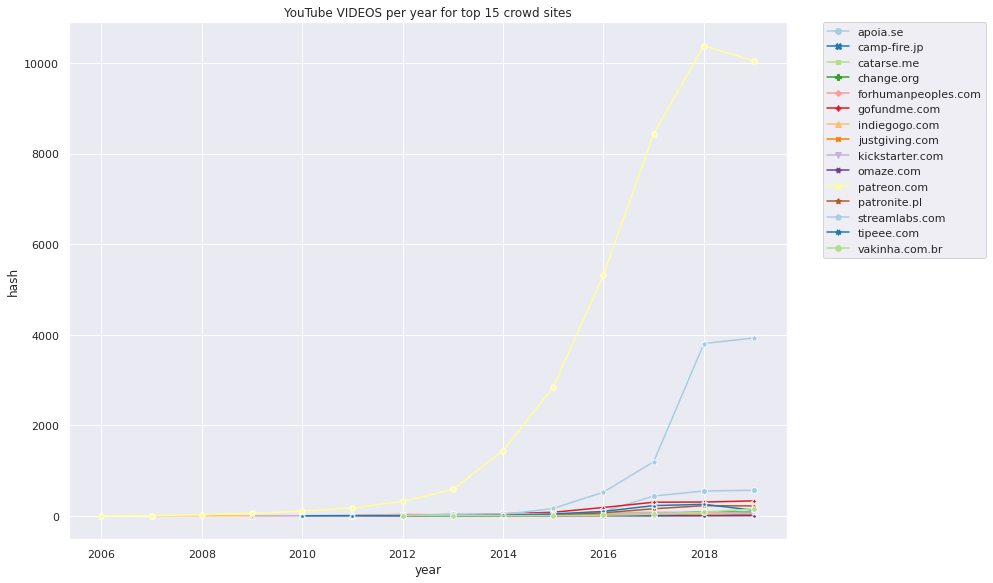

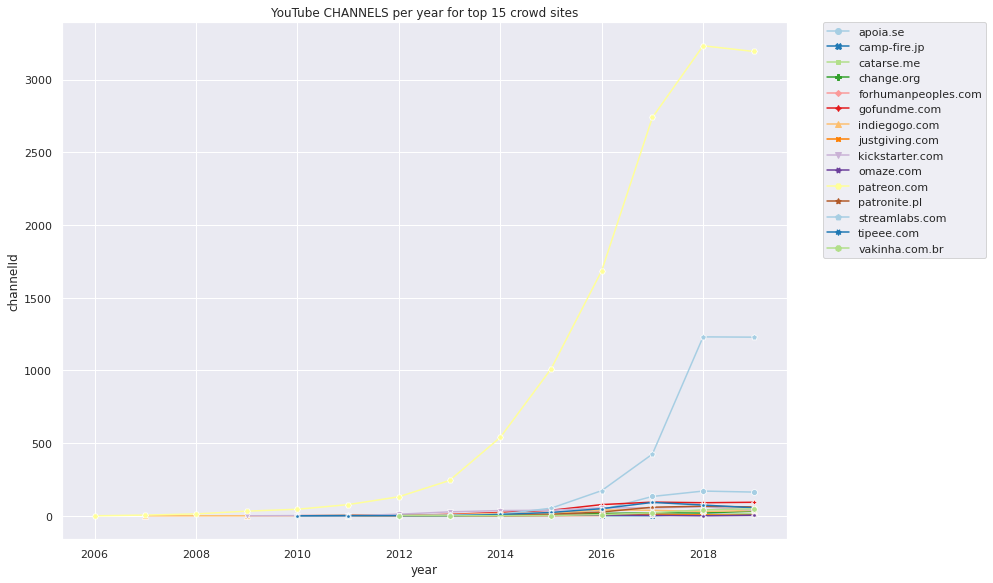

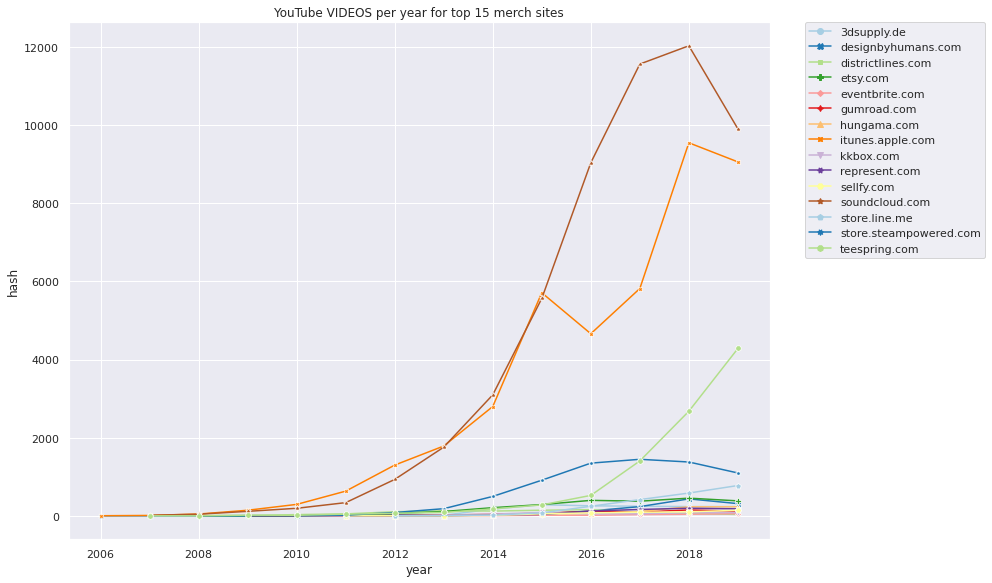

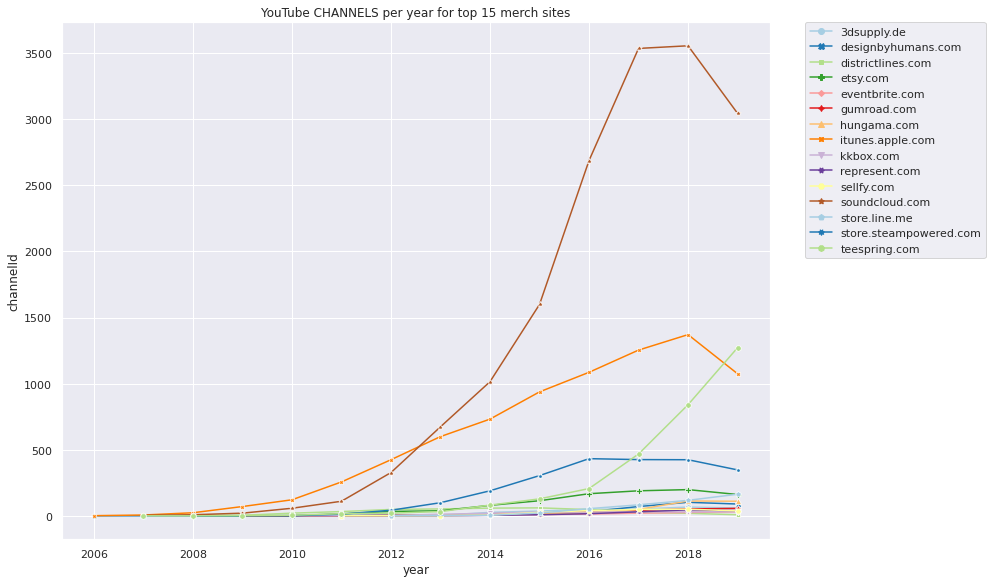

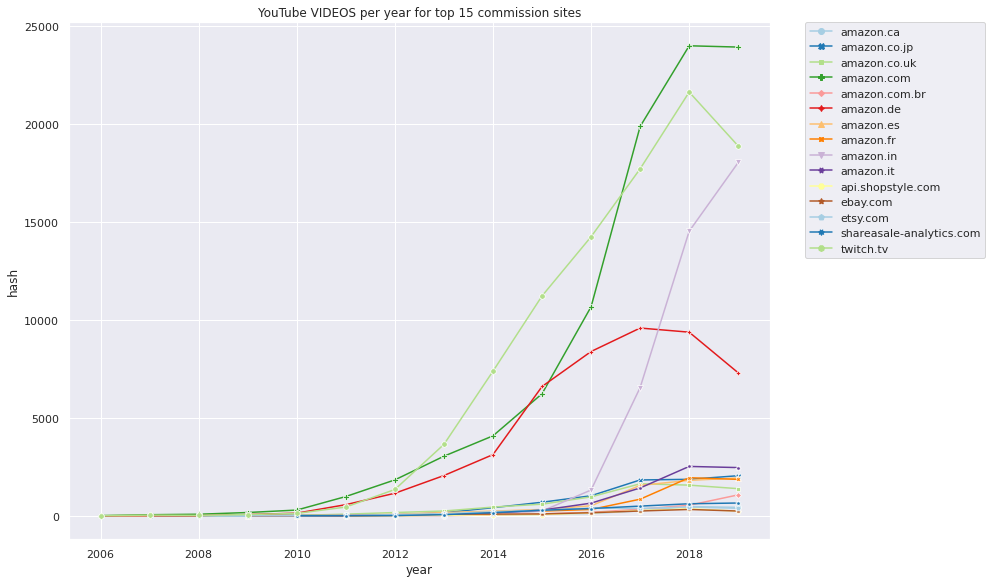

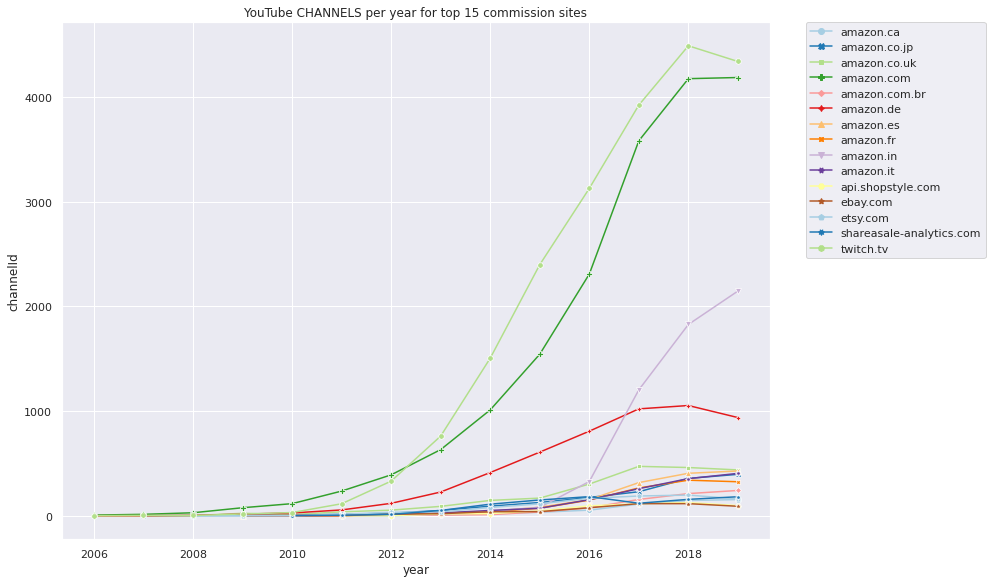

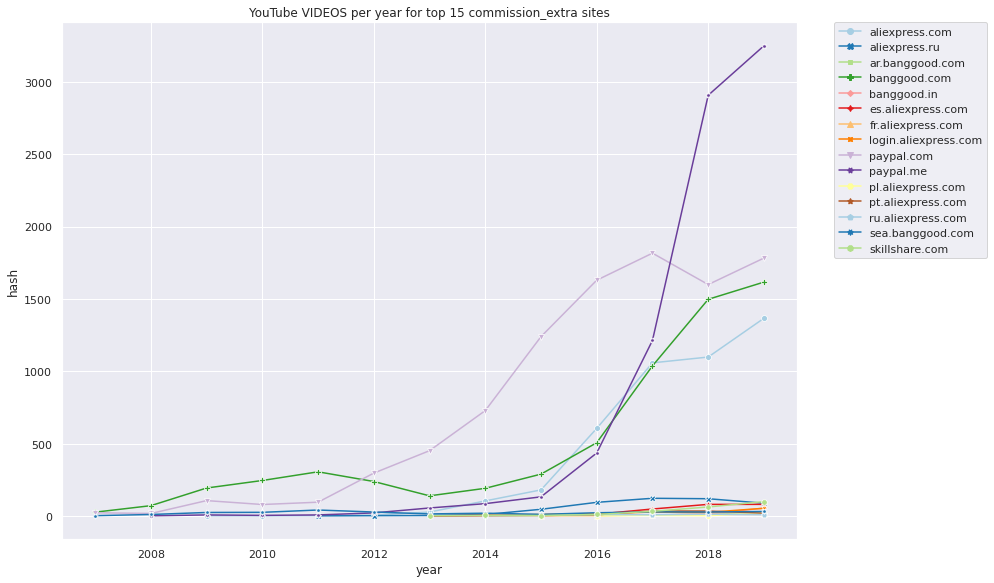

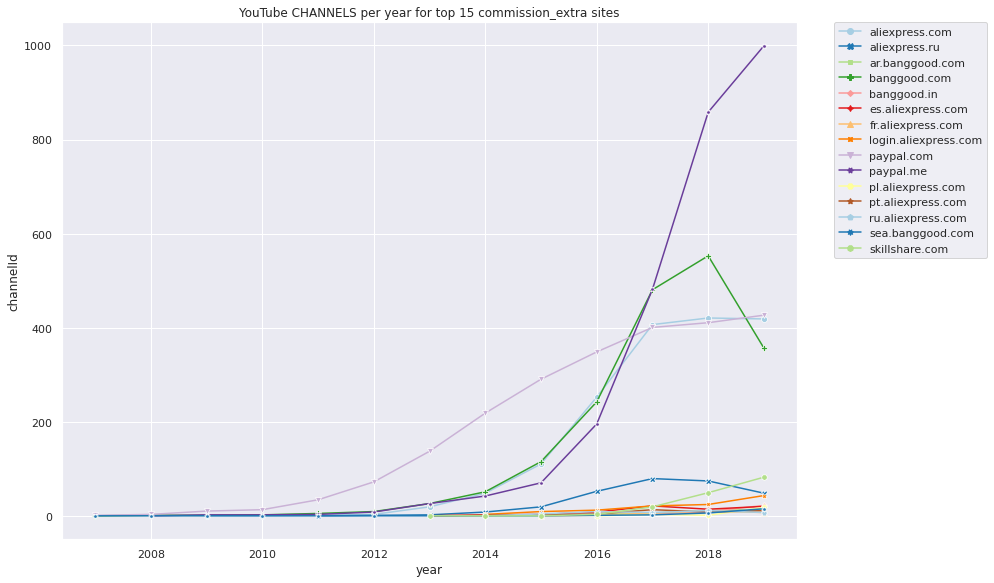

In [26]:
domain_stats = {}
for type in ['crowd','merch','commission','commission_extra']:

    ''' Describe '''
    domain_stats[type] = pd_url_data[['domain','channelCountForDomain','videoCountForDomain','channelDivVideoForDomain']][pd_url_data[type]==True].drop_duplicates()

    # print header
    print("%s domain count" % type)
    if type == "commission" or type == "commission_extra":
        print(domain_stats[type][domain_stats[type].isna().any(axis=1)])
        domain_stats[type]=domain_stats[type].dropna()
    # print most used TYPE domains
    domain_stats[type]['channelCountForDomain'] = domain_stats[type]['channelCountForDomain'].astype(int)
    domain_stats[type]['videoCountForDomain'] = domain_stats[type]['videoCountForDomain'].astype(int)

    with pd.option_context('display.precision', 3):
        display(domain_stats[type].sort_values(by=['channelCountForDomain','channelDivVideoForDomain'],ascending=False).head(limit).style.hide_index())
        print("\n")
        # print TYPE domain stats
        print("%s domain stats" % type)
        print(domain_stats[type].describe())
        print("\n")

    ''' Graph '''

    # filter pd_url_data to only retain info for rows with TYPE domain
    filtered = {}
    filtered[type] = pd_url_data[pd_url_data[type]==True]

    # limit data by top overall TYPE domain for graph
    top_domains = {}
    top_domains[type] = domain_stats[type].sort_values(by="channelCountForDomain",ascending=False)['domain'][0:limit]
    filtered_limited = {}
    filtered_limited[type] = filtered[type][filtered[type]['domain'].isin(top_domains[type])==True]

    # get number of unique domains for color palette in graph 
    num_domains = {}
    num_domains[type] = len(filtered_limited[type]['domain'].unique())
    color_palette = {}
    color_palette[type] = sns.color_palette("Paired",n_colors=num_domains[type])

    # count videos by TYPE domain and year
    filtered_limited_count = {}
    filtered_limited_count[type] = filtered_limited[type].groupby(["domain","year"])['hash'].nunique()
    filtered_limited_count[type] = filtered_limited_count[type].to_frame()
    filtered_limited_count[type].reset_index(inplace=True)
    
    # plot rise of TYPE sites, for videos per year
    plt.figure()
    sns.lineplot(x="year", y="hash", hue="domain", style="domain", palette = color_palette[type], markers=True, dashes=False, data=filtered_limited_count[type])
    plt.title("YouTube VIDEOS per year for top %s %s sites" % (limit,type))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()

    # count channels by TYPE domain and year
    filtered_limited_count = {}
    filtered_limited_count[type] = filtered_limited[type].groupby(["domain","year"])['channelId'].nunique()
    filtered_limited_count[type] = filtered_limited_count[type].to_frame()
    filtered_limited_count[type].reset_index(inplace=True)

    # plot rise of TYPE sites, for channels per year
    plt.figure()
    sns.lineplot(x="year", y="channelId", hue="domain", style="domain", palette = color_palette[type], markers=True, dashes=False, data=filtered_limited_count[type])
    plt.title("YouTube CHANNELS per year for top %s %s sites" % (limit,type))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()


## @todo

* Work on the referral list
   * √ Observations
      * √ not all monetization sites are part of our list getshirts.de
      * √ Stuff definitely missing on our lists: getshirts.de, amazon.{tld}, banggood, aliexpress, skillshare, …
   * √ Get 1000 domains of all URLs (overall and based on channel)
      * √ Already qualify as crowd, merch, commission
      * Continue the rest of the sites and see whether they should be included or added to (other) list via emergent (grounded theory) coding
   * √ match on host (instead of domain)
* Overall observations
   * √ Background graph: number of URLs per year
   * √ Make RankFlow of top domains per year
   * √ Add diversity for Domains, top deep links
   * √ How many domains for 80% coverage?
   * Where are squarespace and dbrand
   * Diversity count in top host domain list + add whether it was in a partner program

Always have two components
- domains, categories. Both are interesting. Domains for

* Breakdowns
   * subscriber / viewer tier (monetization categories)
   * language & locale (domains, e.g. top domains per locale)
   * category (channel & video)
   * year

Channel data set
* Fuse this with channels data set. Finding a way to use the URLs to characterize channels.
   * Channel categories. What hasn't been done at all in the last paper is looking at video categories. That may be done interestingly. Monetization per channel category. Channel classification is not done by video creators. 
	   * b = DataFrame(a.var1.str.split('|').tolist(), index=a.var2).stack()
	   * b = b.reset_index()[[0, 'var2']] # var1 variable is currently labeled 0
	   * b.columns = ['var1', 'var2'] # renaming var1
   * Merch and monetization per channel. When did they introduce this?
   * Whether channels changed merch or crowd-financing, giving that they not backport.
* Compare channel categories vs video categories. (But we need to import mysql database.) Is gonna be important when looking at descriptions and tags and such.
* Think of categories in terms of scatter plots. E.g. crowd funding vs merch and category. Size is number of videos.
* Via topic and/or video categories. E.g. gaming may have a very different URL profile then news/politics. 
* Merch stores with particular topical affinity (e.g. alt-right channels use store X) - alternative ways of classifying youtube. Otherway around: categories that are more suited to crowd-funding than others.

Alternative modes of classification? 
* For a channel we have channel description, keywords, all video titles and keywords. Run as a topic model.
* Video categories are unique and chosen by uploaders
* Channel category column can have several channels, is assigned done automatically by YouTube
* (channels have keywords too, which are much more descriptive. But long-tail, language specific)

Later
* Why are there ⅓ of URLs going to youtube.com and what do they link to (videos, channels?) Are they building a network, just like featuring or subscribing?
* Is the presence of other platforms a sign of cross-platform activity?
* Look into the means of production, e.g. free audio
* what kind of channels linked to the academic publishers?
* look into what's missing. The "(note-)book" of the dead.
	* https://www.youtube.com/error?src=404
	* unacademy.com/unavailable
* graphs, instead of absolute numbers, divide into number of videos per year
* Patreon pledgers, crowd-funding sites/pledges.
* Collect ASINs. How many different products are being advertised (most popular producst - # videos, #views; youtube as amazon catalogue).
* Each URL may afford something for analysis.
* Cross-language analysis. (Videos have language, channels have country flag). 